# Universidad de Buenos Aires
## Deep Learning - TP1

### _Alumno: Natanael Emir Ferrán_
### _Cohorte: 12_

### Ejercicio 1



Se quiere encontrar el máximo de la siguiente función:

$z = -(x - 2)^2 - (y - 3)^2 + 4$
<br>
<br>
1. Aplicar gradiente de forma analítica e igualar a zero para encontrar los valores de $x$ e $y$ donde $z$ tiene un máximo. Cuál es el valor del máximo?

2. Aplicar SGD para encontrar la ubicación del máximo de manera numérica (pueden utilizar pytorch). Comparar con el resultado obtenido en el punto 1

#### Solución

A fin de obtener los puntos críticos de la función $z$, obtenemos sus derivadas primeras y las igualamos a 0:

$$ \frac{dz}{dx} = -2(x-2) = 0 $$

$$ \frac{dz}{dy} = -2(x-3) = 0 $$

$$ x = 2 $$

$$ y = 3 $$

A raíz de estos resultados, observamos que contamos con un único punto crítico $(2,3)$.

A fin de conocer si se trata de un máximo, un mínimo o un punto de inflexión, armamos la _matriz hessiana_ y analizamos sus autovalores. La misma se conforma de la siguiente manera:

$$ H(z) =
\begin{pmatrix}
\frac{d^{2}z}{dx^{2}} & \frac{d^{2}z}{dxdy} \\
\frac{d^{2}z}{dydx} & \frac{d^{2}z}{dy^{2}}
\end{pmatrix}
$$

Entonces calculamos:

$$ \frac{d^{2}z}{dx^{2}} = -2 $$

$$ \frac{d^{2}z}{dxdy} = 0 $$

$$\frac{d^{2}z}{dydx}=0$$

$$\frac{d^{2}z}{dy^{2}}=-2$$

Reemplazamos y obtenemos:

$$ H(z) =
\begin{pmatrix}
-2 & 0 \\
0 & -2
\end{pmatrix}
$$

Como los autovalores son ambos negativos, entonces concluímos que el punto crítico encontrado se trata de un máximo.

Finalmente, reemplazamos los valores de $x$ y $y$ en la función $z$ a fin de obtener el valor del máximo:

$$
z(x=2,y=3) = -(2-2)^{2}-(3-3)^{2}+4 = 4
$$

***


Seguidamente, utilizaremos `pytorch` para resolver el ejercicio con SGD:

In [1]:
# first we import libraries
import torch
from tqdm import tqdm

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# defining function
def function(x, y):
    return -(x - 2)**2 - (y - 3)**2 + 4

# we initialize variables
x = torch.tensor([0.0], requires_grad=True)
y = torch.tensor([0.0], requires_grad=True)

# choosing HP
lr = 0.001
epochs = 5000

# starting loop
for epoch in tqdm(range(epochs)):

    # calculating output
    output = function(x, y)
    
    # getting gradients
    output.backward()
    
    # updating variables
    x.data = x.data + lr * x.grad.data
    y.data = y.data + lr * y.grad.data
    
    # restarting gradients
    x.grad.data.zero_()
    y.grad.data.zero_()

# print results
print("x:", x.item())
print("y:", y.item())
print("Max value obtained:", output.item())

100%|██████████| 5000/5000 [00:01<00:00, 3823.23it/s]

x: 1.9999114274978638
y: 2.999856948852539
Max value obtained: 4.0


### Ejercicio 2


Descargar el dataset del siguiente link: https://drive.google.com/file/d/1eFWn7eDmSFUK1JuuBBykxkC9J0CGYDKe/view?usp=sharing.

El dataset contiene mediciones obtenidas al ensayar un sistema de posicionamiento. El sistema consiste en un dispositivo móvil del cual se desea conocer la posición y 13 "balizas" fijas (distribuidas en un salón) que emiten señales de radio.

Cada fila del dataset contiene una posición del dispositivo móvil y los niveles de señal recibida (de las señales emitidas por cada una de las 13 balizas fijas) en dicha posición.

![Salon](https://drive.google.com/uc?export=view&id=1z3uHEd3tS1kQpGXfhPYn2GFfA95v_ArW)


Algunas consideraciones:
- La imágen anterior es orientativa, no se encuentra a escala ni representa la verdadera posición de las balizas fijas.
- La posición en el salón se divide en una cuadrícula. La posición horizontal se codifica con una letra de la A a la Z y la posición vertical se codifica con valores de 01 a 20.
- El nivel de señal recibida se mide de 0 (máximo teórico) a -200 (mínimo teórico). NA significa que no se recibe señal de la baliza en dicha posición. A efectos prácticos no recibir señal (NA) es equivalente a recibir una señal con nivel -200.

**Consignas:**

1. Analizar el dataset y aplicar las transformaciones que considere necesarias para entrenar un modelo de red neuronal.

2. Entrenar un modelo de **Deep Learning** con múltiples capas lineales que prediga la posición del dispositivo móvil en el salón (vertical y horizontal) a partir de las mediciones de los niveles de las 13 balizas. Graficar la evolución de la función de pérdida y la evolución de la métrica [MAE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) durante el entrenamiento.

3. Comprobar el funcionamiento del modelo realizando una predicción sobre una muestra aleatoria del dataset y comparar con la posición real.

Con la finalidad de ahorrar energía en el dispositivo móvil y simplificar el sistema, se quiere ensayar la posibilidad de predecir la posición solamente con la información del nivel de señal de las 2 balizas mas cercanas.

4. Aplicar las transformaciones necesarias sobre el dataset para obtener un nuevo dataset que contenga solamente la información de las 2 balizas con mayor nivel de señal (ver imágen adjunta). Si no se recibe señal de una 2da baliza, proponer un método para completar la información faltante.

![Dataset Punto 4](https://drive.google.com/uc?export=view&id=1kz1Y5m5rmbYPiuZIc4QHvnt4uFB2TwWu)


5. Entrenar un modelo de **Deep Learning** que prediga la posición del dispositivo móvil en el salón (vertical y horizontal) a partir del dataset del punto 4, incluyendo **una capa de embeddings** para ambos número (o IDs) de balizas.

6. Comparar los resultados obtenidos con los modelo de los puntos 2 y 5 y enunciar conclusiones.

#### Solución

In [3]:
# first we import essential libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [4]:
# reading data
url= 'https://raw.githubusercontent.com/nferran/tp_deep_learning/main/Positioning_data.csv'
df= pd.read_csv(url)
df.head()

,Pos,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13
0,O02,NaN,NaN,NaN,NaN,NaN,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P01,NaN,NaN,NaN,NaN,NaN,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P01,NaN,NaN,NaN,NaN,NaN,-77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P01,NaN,NaN,NaN,NaN,NaN,-77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P01,NaN,NaN,NaN,NaN,NaN,-77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# checking basic info
df.shape

(1420, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pos       1420 non-null   object 
 1   Baliza1   25 non-null     float64
 2   Baliza2   497 non-null    float64
 3   Baliza3   280 non-null    float64
 4   Baliza4   402 non-null    float64
 5   Baliza5   247 non-null    float64
 6   Baliza6   287 non-null    float64
 7   Baliza7   50 non-null     float64
 8   Baliza8   91 non-null     float64
 9   Baliza9   31 non-null     float64
 10  Baliza10  29 non-null     float64
 11  Baliza11  25 non-null     float64
 12  Baliza12  35 non-null     float64
 13  Baliza13  44 non-null     float64
dtypes: float64(13), object(1)
memory usage: 155.4+ KB


In [7]:
# checking NaN existence
df.isna().sum(axis=0)

Pos            0
Baliza1     1395
Baliza2      923
Baliza3     1140
Baliza4     1018
Baliza5     1173
Baliza6     1133
Baliza7     1370
Baliza8     1329
Baliza9     1389
Baliza10    1391
Baliza11    1395
Baliza12    1385
Baliza13    1376
dtype: int64

In [8]:
# replacing NaN with -200 
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= -200.0)
df_transformed= imp.fit_transform(df)
df_transformed= pd.DataFrame(data= df_transformed, columns= df.columns)

df_transformed.head()

,Pos,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13
0,O02,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
1,P01,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
2,P01,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
3,P01,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0
4,P01,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0


In [9]:
# re-checking NaN existence
df_transformed.isna().sum(axis=0)

Pos         0
Baliza1     0
Baliza2     0
Baliza3     0
Baliza4     0
Baliza5     0
Baliza6     0
Baliza7     0
Baliza8     0
Baliza9     0
Baliza10    0
Baliza11    0
Baliza12    0
Baliza13    0
dtype: int64

In [10]:
# checking data types
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pos       1420 non-null   object
 1   Baliza1   1420 non-null   object
 2   Baliza2   1420 non-null   object
 3   Baliza3   1420 non-null   object
 4   Baliza4   1420 non-null   object
 5   Baliza5   1420 non-null   object
 6   Baliza6   1420 non-null   object
 7   Baliza7   1420 non-null   object
 8   Baliza8   1420 non-null   object
 9   Baliza9   1420 non-null   object
 10  Baliza10  1420 non-null   object
 11  Baliza11  1420 non-null   object
 12  Baliza12  1420 non-null   object
 13  Baliza13  1420 non-null   object
dtypes: object(14)
memory usage: 155.4+ KB


In [11]:
# fixing wrong data types
df_transformed[['Baliza1', 'Baliza2', 'Baliza3', 'Baliza4', 'Baliza5', 'Baliza6','Baliza7', 'Baliza8', 'Baliza9', 'Baliza10', 'Baliza11', 'Baliza12','Baliza13']] = df_transformed[['Baliza1', 'Baliza2', 'Baliza3', 'Baliza4', 'Baliza5', 'Baliza6','Baliza7', 'Baliza8', 'Baliza9', 'Baliza10', 'Baliza11', 'Baliza12','Baliza13']].apply(pd.to_numeric)

In [12]:
# re-checking data types
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pos       1420 non-null   object 
 1   Baliza1   1420 non-null   float64
 2   Baliza2   1420 non-null   float64
 3   Baliza3   1420 non-null   float64
 4   Baliza4   1420 non-null   float64
 5   Baliza5   1420 non-null   float64
 6   Baliza6   1420 non-null   float64
 7   Baliza7   1420 non-null   float64
 8   Baliza8   1420 non-null   float64
 9   Baliza9   1420 non-null   float64
 10  Baliza10  1420 non-null   float64
 11  Baliza11  1420 non-null   float64
 12  Baliza12  1420 non-null   float64
 13  Baliza13  1420 non-null   float64
dtypes: float64(13), object(1)
memory usage: 155.4+ KB


In [13]:
# working in target's format
# defining function to split each position in two axis, X and Y
def split_at(obj, index):
    return obj[:index], obj[index:]

# applying split
df_transformed['Pos']= df_transformed['Pos'].apply(lambda x: split_at(x, 1))

# creating two new columns
df_transformed[['PosX', 'PosY']] = df_transformed['Pos'].apply(lambda x: pd.Series(x))

# dropping old column
df_transformed= df_transformed.drop('Pos', axis= 1)

# fixing data type
df_transformed['PosY']= df_transformed['PosY'].apply(pd.to_numeric)

df_transformed.head()


,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13,PosX,PosY
0,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,O,2
1,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,P,1
2,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,P,1
3,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,P,1
4,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,P,1


In [14]:
# working in PosX format
# defining function to transform letters to integers
def letter2number(l):
    number= ord(l) - ord('A') + 1
    return number

# applying transformation
df_transformed['PosX']= df_transformed['PosX'].apply(lambda x: letter2number(x))

# fixing data type
df_transformed['PosX']= df_transformed['PosX'].apply(pd.to_numeric)

df_transformed.head()

,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13,PosX,PosY
0,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,15,2
1,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1
2,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1
3,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1
4,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1


In [15]:
# final check of data types
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Baliza1   1420 non-null   float64
 1   Baliza2   1420 non-null   float64
 2   Baliza3   1420 non-null   float64
 3   Baliza4   1420 non-null   float64
 4   Baliza5   1420 non-null   float64
 5   Baliza6   1420 non-null   float64
 6   Baliza7   1420 non-null   float64
 7   Baliza8   1420 non-null   float64
 8   Baliza9   1420 non-null   float64
 9   Baliza10  1420 non-null   float64
 10  Baliza11  1420 non-null   float64
 11  Baliza12  1420 non-null   float64
 12  Baliza13  1420 non-null   float64
 13  PosX      1420 non-null   int64  
 14  PosY      1420 non-null   int64  
dtypes: float64(13), int64(2)
memory usage: 166.5 KB


In [16]:
# splitting data
from sklearn.model_selection import train_test_split

x= df_transformed.drop(['PosX','PosY'], axis= 1).values
y= df_transformed[['PosX','PosY']].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, stratify= y)

n_train= X_train.shape[0]
n_test= X_test.shape[0]

In [17]:
# creating dataset in order to work with pytorch
class MyDataset(Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [18]:
# creating train and test sets
train_ds= MyDataset(X_train, y_train)
test_ds= MyDataset(X_test, y_test)

In [19]:
# checking getitem correct functionality
train_ds[20]

(array([ -70., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200., -200., -200.]),
 array([6, 8]))

In [20]:
test_ds[20]

(array([-200.,  -69., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200., -200., -200.]),
 array([9, 4]))

In [21]:
# checking len correct functionality
len(train_ds)

994

In [22]:
len(test_ds)

426

In [23]:
# creating batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
test_dataloader = DataLoader(test_ds, batch_size= 64)

In [24]:
# creating NN class
class NNet(torch.nn.Module):

  def __init__(self):
    # defining NN architecture
    super().__init__()
    self.linear_1= torch.nn.Linear(in_features= 13, out_features= 20, bias= True)
    self.relu_1= torch.nn.ReLU()
    self.linear_2= torch.nn.Linear(in_features= 20, out_features= 15, bias= True)
    self.relu_2= torch.nn.ReLU()
    self.linear_3= torch.nn.Linear(in_features= 15, out_features= 2, bias= True)

  def forward(self, x):
    # defining forward propagation calculation
    x= self.linear_1(x)
    x= self.relu_1(x)
    x= self.linear_2(x)
    x= self.relu_2(x)
    x= self.linear_3(x)

    return x

In [25]:
# initialize and check NN schema
nnet= NNet()
print(nnet)

NNet(
  (linear_1): Linear(in_features=13, out_features=20, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=20, out_features=15, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=15, out_features=2, bias=True)
)


In [26]:
# checking quantity of trainable parameters
print(sum(p.numel() for p in nnet.parameters()))

627


In [27]:
# choosing loss function and optimizer
loss_function= torch.nn.MSELoss()
optimizer= torch.optim.Adam(nnet.parameters(), lr= 0.001)

In [28]:
# using gpu if available
device= "cpu"
if torch.cuda.is_available():
  device= "cuda:0"

device

'cpu'

In [29]:
# mounting NN in device 
nnet= nnet.to(device)

In [30]:
# epochs quantity
epochs= 50

train_loss_by_epoch= []
test_loss_by_epoch= []
epoch_mae= []
test_epoch_mae= []

# Mini-Batch training
for epoch in range(epochs):
  
  ############################################
  ## Training
  ############################################
  nnet.train(True)

  epoch_loss= 0
  epoch_y_hat= []
  epoch_y= []
  
  for i,data in enumerate(train_dataloader):
    # getting data from training batches
    x_batch, y_batch= data
    # copying data to device
    x_batch= x_batch.to(device).float()
    y_batch= y_batch.to(device).float()

    #### forward propagation ####
    # restarting gradients
    optimizer.zero_grad()
    y_batch_hat= nnet(x_batch)
    
    # Loss calculation
    loss= loss_function(y_batch_hat, y_batch)

    #### backpropagation ####
    loss.backward()

    # updating parameters
    optimizer.step()
    
    # saving predictions and true values to calculate metrics
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

    # save batch-loss
    epoch_loss = epoch_loss + loss.item()

  # loss-mean
  epoch_loss = epoch_loss / n_train
  # save epoch loss to graph
  train_loss_by_epoch.append(epoch_loss)
  # calculate epoch metrics
  mae= metrics.mean_absolute_error(epoch_y, epoch_y_hat)
  # save mae to graph
  epoch_mae.append(mae)

  ############################################
  ## Testing
  ############################################
  # disable gradient calculation
  nnet.train(False)

  test_epoch_loss = 0
  test_epoch_y_hat = []
  test_epoch_y = []

  for i,data in enumerate(test_dataloader):
    # getting data from testing batches
    x_batch, y_batch= data
    # copying data to device
    x_batch= x_batch.to(device).float()
    y_batch= y_batch.to(device).float()

    #### forward propagation ####
    y_batch_hat= nnet(x_batch)
    
    # Loss calculation
    loss= loss_function(y_batch_hat, y_batch)

    # save batch-loss
    test_epoch_loss = test_epoch_loss + loss.item()

    # saving predictions and true values to calculate metrics
    test_epoch_y += list(y_batch.detach().cpu().numpy())
    test_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

  # loss-mean
  test_epoch_loss = test_epoch_loss / n_test
  # save epoch loss to graph
  test_loss_by_epoch.append(test_epoch_loss)
  # calculate epoch metrics
  test_mae= metrics.mean_absolute_error(test_epoch_y, test_epoch_y_hat)
  test_epoch_mae.append(test_mae)

  ############################################
  ### print results per epoch
  ############################################
  print(f"Epoch {epoch} | " \
        f"Train/Test loss: {epoch_loss:.3f} / {test_epoch_loss:.3f} | " \
        f"Train/Valid MAE: {mae:.3f} / {test_mae:.3f}")

Epoch 0 | Train/Test loss: 4.806 / 1.977 | Train/Valid MAE: 13.288 / 9.023
Epoch 1 | Train/Test loss: 1.069 / 0.573 | Train/Valid MAE: 6.541 / 4.644
Epoch 2 | Train/Test loss: 0.402 / 0.296 | Train/Valid MAE: 3.901 / 3.272
Epoch 3 | Train/Test loss: 0.283 / 0.263 | Train/Valid MAE: 3.310 / 3.115
Epoch 4 | Train/Test loss: 0.245 / 0.232 | Train/Valid MAE: 3.012 / 2.899
Epoch 5 | Train/Test loss: 0.225 / 0.212 | Train/Valid MAE: 2.839 / 2.764
Epoch 6 | Train/Test loss: 0.207 / 0.198 | Train/Valid MAE: 2.740 / 2.681
Epoch 7 | Train/Test loss: 0.190 / 0.186 | Train/Valid MAE: 2.641 / 2.599
Epoch 8 | Train/Test loss: 0.178 / 0.176 | Train/Valid MAE: 2.551 / 2.543
Epoch 9 | Train/Test loss: 0.168 / 0.167 | Train/Valid MAE: 2.487 / 2.467
Epoch 10 | Train/Test loss: 0.159 / 0.156 | Train/Valid MAE: 2.416 / 2.386
Epoch 11 | Train/Test loss: 0.147 / 0.144 | Train/Valid MAE: 2.304 / 2.258
Epoch 12 | Train/Test loss: 0.136 / 0.130 | Train/Valid MAE: 2.163 / 2.075
Epoch 13 | Train/Test loss: 0.123 

Epoch 34 | Train/Test loss: 0.045 / 0.058 | Train/Valid MAE: 1.288 / 1.434
Epoch 35 | Train/Test loss: 0.047 / 0.057 | Train/Valid MAE: 1.298 / 1.407
Epoch 36 | Train/Test loss: 0.045 / 0.058 | Train/Valid MAE: 1.287 / 1.421
Epoch 37 | Train/Test loss: 0.045 / 0.057 | Train/Valid MAE: 1.266 / 1.406
Epoch 38 | Train/Test loss: 0.045 / 0.055 | Train/Valid MAE: 1.284 / 1.357
Epoch 39 | Train/Test loss: 0.044 / 0.055 | Train/Valid MAE: 1.270 / 1.371
Epoch 40 | Train/Test loss: 0.044 / 0.058 | Train/Valid MAE: 1.267 / 1.439
Epoch 41 | Train/Test loss: 0.043 / 0.055 | Train/Valid MAE: 1.246 / 1.380
Epoch 42 | Train/Test loss: 0.044 / 0.055 | Train/Valid MAE: 1.256 / 1.395
Epoch 43 | Train/Test loss: 0.043 / 0.054 | Train/Valid MAE: 1.248 / 1.369
Epoch 44 | Train/Test loss: 0.042 / 0.053 | Train/Valid MAE: 1.234 / 1.357
Epoch 45 | Train/Test loss: 0.042 / 0.052 | Train/Valid MAE: 1.228 / 1.343
Epoch 46 | Train/Test loss: 0.042 / 0.052 | Train/Valid MAE: 1.236 / 1.338
Epoch 47 | Train/Test los

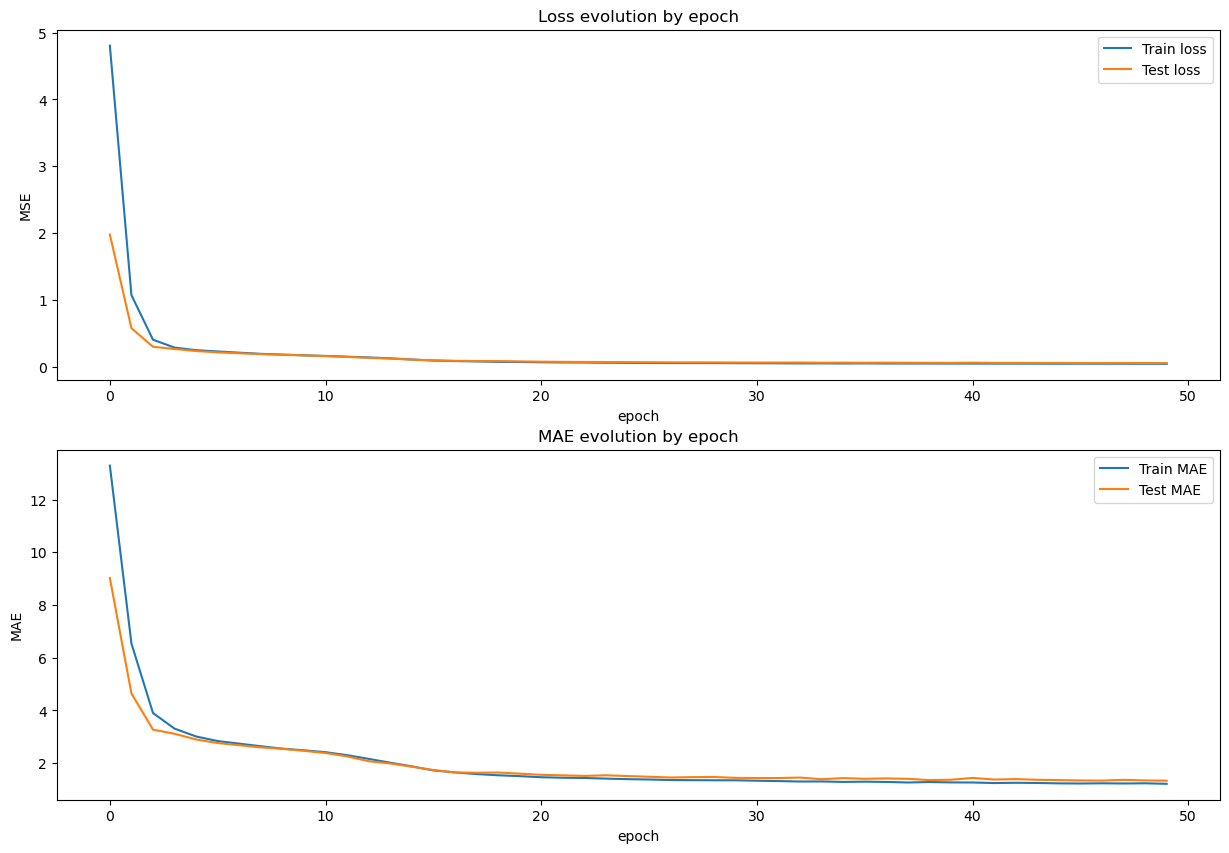

In [31]:
# graphing loss and MAE per epoch

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
ax[0].plot(train_loss_by_epoch, label="Train loss")
ax[0].plot(test_loss_by_epoch, label="Test loss")
ax[0].legend()
ax[0].set_title("Loss evolution by epoch")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("MSE")

ax[1].plot(epoch_mae, label="Train MAE")
ax[1].plot(test_epoch_mae, label="Test MAE")
ax[1].legend()
ax[1].set_title("MAE evolution by epoch")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("MAE")

plt.show()

In [32]:
# turning model into evaluation mode
nnet.eval()
# choosing example to predict 
to_predict= X_test[10]
# converting to torch tensor
to_predict= torch.tensor(to_predict, dtype=torch.float32)
# making prediction
with torch.no_grad():
    predicted_value= nnet(to_predict)

print("Prediction:", predicted_value.numpy(), '\nTrue value:', y_test[10])

Prediction: [20.733347 13.576141] 
True value: [21 15]


In [33]:
# creating a new dataset
df_transformed2= df_transformed.copy()
# creating an inputs dataset
df_inputs= df_transformed2.drop(['PosX','PosY'], axis= 1)
# getting name of the column with highest value
max_column_names= df_inputs.idxmax(axis=1)
# getting highest value
max_values = df_inputs.max(axis=1)
# adding columns to new dataset
df_transformed2['Baliza_maxima_señal'] = max_column_names
df_transformed2['Maxima_señal'] = max_values

df_transformed2.head(7)

,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13,PosX,PosY,Baliza_maxima_señal,Maxima_señal
0,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,15,2,Baliza6,-78.0
1,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-78.0
2,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0
3,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0
4,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0
5,-200.0,-200.0,-82.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza3,-82.0
6,-200.0,-200.0,-80.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0


In [34]:
# getting column name of the second highest value
df_transformed2['Baliza_2da_maxima_señal'] = df_inputs.apply(lambda row: row.nlargest(2).idxmin(), axis=1)
# getting second highest value
df_transformed2['2da_maxima_señal'] = df_inputs.apply(lambda row: row.nlargest(2).min(), axis=1)

df_transformed2.head(7)

,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13,PosX,PosY,Baliza_maxima_señal,Maxima_señal,Baliza_2da_maxima_señal,2da_maxima_señal
0,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,15,2,Baliza6,-78.0,Baliza1,-200.0
1,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-78.0,Baliza1,-200.0
2,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Baliza1,-200.0
3,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Baliza1,-200.0
4,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Baliza1,-200.0
5,-200.0,-200.0,-82.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza3,-82.0,Baliza1,-200.0
6,-200.0,-200.0,-80.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Baliza3,-80.0


In [35]:
# in case that there isn't a second highest value, then the column will be named with a custom label

# creating mask
mask = (df_transformed2['2da_maxima_señal'] == -200.0)

# assigning custom label
df_transformed2.loc[mask, 'Baliza_2da_maxima_señal'] = 'Ninguna'

df_transformed2.head(7)

,Baliza1,Baliza2,Baliza3,Baliza4,Baliza5,Baliza6,Baliza7,Baliza8,Baliza9,Baliza10,Baliza11,Baliza12,Baliza13,PosX,PosY,Baliza_maxima_señal,Maxima_señal,Baliza_2da_maxima_señal,2da_maxima_señal
0,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,15,2,Baliza6,-78.0,Ninguna,-200.0
1,-200.0,-200.0,-200.0,-200.0,-200.0,-78.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-78.0,Ninguna,-200.0
2,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Ninguna,-200.0
3,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Ninguna,-200.0
4,-200.0,-200.0,-200.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Ninguna,-200.0
5,-200.0,-200.0,-82.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza3,-82.0,Ninguna,-200.0
6,-200.0,-200.0,-80.0,-200.0,-200.0,-77.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,16,1,Baliza6,-77.0,Baliza3,-80.0


In [36]:
# final version of the new dataset
df_transformed2= df_transformed2.drop(df_inputs.columns, axis= 1)
df_transformed2.head(7)

,PosX,PosY,Baliza_maxima_señal,Maxima_señal,Baliza_2da_maxima_señal,2da_maxima_señal
0,15,2,Baliza6,-78.0,Ninguna,-200.0
1,16,1,Baliza6,-78.0,Ninguna,-200.0
2,16,1,Baliza6,-77.0,Ninguna,-200.0
3,16,1,Baliza6,-77.0,Ninguna,-200.0
4,16,1,Baliza6,-77.0,Ninguna,-200.0
5,16,1,Baliza3,-82.0,Ninguna,-200.0
6,16,1,Baliza6,-77.0,Baliza3,-80.0


In [37]:
# 
balizas_1= df_transformed2['Baliza_maxima_señal']
balizas_2= df_transformed2['Baliza_2da_maxima_señal']
x= df_transformed2[['Maxima_señal','2da_maxima_señal']]
y= df_transformed2[['PosX','PosY']]

In [38]:
#
x= x.to_numpy()
y= y.to_numpy()

In [39]:
#
idx= np.random.permutation(x.shape[0])
train_idx= idx[0:int(0.85*len(idx))]
test_idx= idx[int(0.85*len(idx)):]

train_x= x[train_idx]
train_y= y[train_idx]
test_x= x[test_idx]
test_y= y[test_idx]

n_train= train_x.shape[0]
n_test= test_x.shape[0]

In [40]:
# 
balizas_1_to_idx= {value:i for i,value in enumerate(balizas_1.unique())}
balizas_2_to_idx= {value:i for i,value in enumerate(balizas_2.unique())}

In [41]:
# 
balizas_1_idx= np.array([balizas_1_to_idx[value] for value in balizas_1])
balizas_2_idx= np.array([balizas_2_to_idx[value] for value in balizas_2])

In [42]:
#
balizas_1_idx_train= balizas_1[train_idx]
balizas_1_idx_test= balizas_1[test_idx]

balizas_2_idx_train= balizas_2[train_idx]
balizas_2_idx_test= balizas_2[test_idx]

In [43]:
#
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, balizas_1_idx, balizas_2_idx, y):
    self.x= x
    self.balizas_1_idx= balizas_1_idx
    self.balizas_2_idx= balizas_2_idx
    self.y= y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.balizas_1_idx[idx], self.balizas_2_idx[idx], self.y[idx]

In [46]:
# 
train_ds_embeddings= MyDatasetWithEmbddings(train_x, balizas_1_idx_train, balizas_2_idx_train, train_y)
test_ds_embeddings= MyDatasetWithEmbddings(test_x, balizas_1_idx_test, balizas_2_idx_test, test_y)

In [47]:
# 
train_dataloader_emb= DataLoader(train_ds_embeddings, batch_size= 64, shuffle= True)
test_dataloader_emb= DataLoader(test_ds_embeddings, batch_size= 64)

In [48]:
#
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings1= torch.nn.Embedding(num_embeddings= 13, embedding_dim= 4)
    self.embeddings2= torch.nn.Embedding(num_embeddings= 14, embedding_dim= 4)
    self.linear_1= torch.nn.Linear(in_features= 13+14+2, out_features= 20, bias= True)
    self.relu_1= torch.nn.ReLU()
    self.linear_2= torch.nn.Linear(in_features= 20, out_features= 15, bias= True)
    self.relu_2= torch.nn.ReLU()
    self.linear_3= torch.nn.Linear(in_features= 15, out_features= 2, bias= True)

  def forward(self, x, balizas_1_idx, balizas_2_idx):
    embeddings_outputs_1= self.embeddings1(balizas_1_idx)
    embeddings_outputs_2= self.embeddings2(balizas_2_idx)
    x = torch.cat([x, embeddings_outputs_1, embeddings_outputs_2], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    return x

In [49]:
# 
nnnetWithEmbeddings= NNetWithEmbeddings()
nnnetWithEmbeddings= nnnetWithEmbeddings.to(device)

In [50]:
# choosing loss function and optimizer
loss_function= torch.nn.MSELoss()
optimizer= torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr= 0.001)

In [51]:
# epochs quantity
epochs= 50

train_loss_by_epoch= []
test_loss_by_epoch= []
epoch_mae= []
test_epoch_mae= []

# Mini-Batch training
for epoch in range(epochs):
  
  ############################################
  ## Training
  ############################################
  
  nnnetWithEmbeddings.train(True)

  epoch_loss= 0
  epoch_y_hat= []
  epoch_y= []
  
  for i,data in enumerate(train_dataloader_emb):
    # getting data from training batches
    x_batch, embed_batch_1, embed_batch_2 , y_batch= data
    # copying data to device
    x_batch= x_batch.to(device).float()
    embed_batch_1= embed_batch_1.to(device).int()
    embed_batch_2= embed_batch_2.to(device).int()
    y_batch= y_batch.to(device).float()

    #### forward propagation ####
    # restarting gradients
    optimizer.zero_grad()
    y_batch_hat= nnet(x_batch, embed_batch_1, embed_batch_2)
    
    # Loss calculation
    loss= loss_function(y_batch_hat, y_batch)

    #### backpropagation ####
    loss.backward()

    # updating parameters
    optimizer.step()
    
    # saving predictions and true values to calculate metrics
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

    # save batch-loss
    epoch_loss = epoch_loss + loss.item()

  # loss-mean
  epoch_loss = epoch_loss / n_train
  # save epoch loss to graph
  train_loss_by_epoch.append(epoch_loss)
  # calculate epoch metrics
  mae= metrics.mean_absolute_error(epoch_y, epoch_y_hat)
  # save mae to graph
  epoch_mae.append(mae)

  ############################################
  ## Testing
  ############################################
  # disable gradient calculation
  nnet.train(False)

  test_epoch_loss = 0
  test_epoch_y_hat = []
  test_epoch_y = []

  for i,data in enumerate(test_dataloader_emb):
    # getting data from testing batches
    x_batch, embed_batch_1, embed_batch_2, y_batch= data
    # copying data to device
    x_batch= x_batch.to(device).float()
    embed_batch_1= embed_batch_1.to(device).int()
    embed_batch_2= embed_batch_2.to(device).int()
    y_batch= y_batch.to(device).float()

    #### forward propagation ####
    y_batch_hat= nnet(x_batch, embed_batch_1, embed_batch_2)
    
    # Loss calculation
    loss= loss_function(y_batch_hat, y_batch)

    # save batch-loss
    test_epoch_loss = test_epoch_loss + loss.item()

    # saving predictions and true values to calculate metrics
    test_epoch_y += list(y_batch.detach().cpu().numpy())
    test_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())

  # loss-mean
  test_epoch_loss = test_epoch_loss / n_test
  # save epoch loss to graph
  test_loss_by_epoch.append(test_epoch_loss)
  # calculate epoch metrics
  test_mae= metrics.mean_absolute_error(test_epoch_y, test_epoch_y_hat)
  test_epoch_mae.append(test_mae)

  ############################################
  ### print results per epoch
  ############################################
  print(f"Epoch {epoch} | " \
        f"Train/Test loss: {epoch_loss:.3f} / {test_epoch_loss:.3f} | " \
        f"Train/Valid MAE: {mae:.3f} / {test_mae:.3f}")

KeyError: 367

In [ ]:
# graphing loss and MAE per epoch

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,10))
ax[0].plot(train_loss_by_epoch, label="Train loss")
ax[0].plot(test_loss_by_epoch, label="Test loss")
ax[0].legend()
ax[0].set_title("Loss evolution by epoch")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("MSE")

ax[1].plot(epoch_mae, label="Train MAE")
ax[1].plot(test_epoch_mae, label="Test MAE")
ax[1].legend()
ax[1].set_title("MAE evolution by epoch")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("MAE")

plt.show()